In [16]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from models.batchLoader import BatchLoader
from models.unetResidual import UnetResidual
from models.unet import Unet

In [17]:
#model_file_name = 'unet-residual-dice.h5'
model_file_name = 'unet-baseline.h5'
#model_file_name = 'unet-large.h5'
#model_file_name = 'unet-residual.h5'
model_name = 'U-net Baseline'
image_size = (256, 256)
batch_size = 10
image_folder = 's2cloudless_imagery'
#image_folder = 'nwpu_images'
mask_folder = 's2cloudless_label_imagery'
#mask_folder = 'nwpu_label_images'
#model = UnetResidual(model_name, image_size)
model = Unet(model_name, image_size, version=1)
model.restore(model_file_name)
images = glob.glob(os.path.join(image_folder, 'data', '*.jpg'))

In [18]:
def mean_iou(y_true, y_pred):
    threshold = 0.5
    yt0 = y_true[:, :, :, 0]
    yp0 = tf.keras.backend.cast(y_pred[:, :, :, 0] > threshold, 'float32')
    intersection = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1.0, tf.cast(intersection/union, 'float32'))
    return iou.numpy()

def pair_image_with_mask(image, mask):
    mask = mask.squeeze()
    mask = np.stack((mask,) * 3, axis=-1)
    return np.concatenate([image, mask], axis = 1)

def display_predictions(X, Y, batch_size):
    columns_count = 2
    figure_size = (8, 10)
    rows = batch_size // columns_count
    _, axs = plt.subplots(rows, columns_count, figsize = figure_size)
    axs = axs.flatten()
    for i in range(batch_size):
        combined = pair_image_with_mask(X[i], Y[i])
        axs[i].axis('off')
        axs[i].imshow(combined)
    plt.tight_layout()

Display a list of the layers in the model.

In [19]:
model.get_model_summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 256, 256, 8)  224         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 256, 256, 8)  584         conv2d_135[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_136[0][0]                 
______________________________________________________________________________________

Create a batch loader to evaluate the model.

In [20]:
batch_loader = BatchLoader(images, image_folder, mask_folder, batch_size, image_size)
batch_generator = batch_loader()

In [21]:
X_test, Y_test = next(batch_generator)

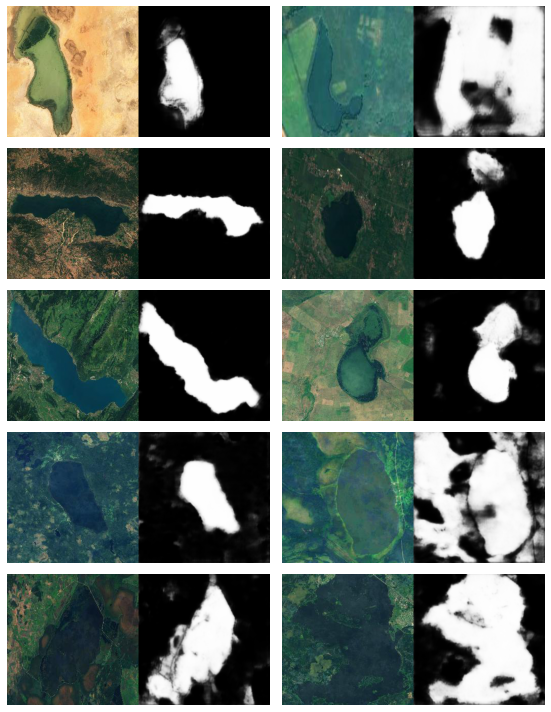

In [22]:
Y_pred = model.predict(X_test)
display_predictions(X_test, Y_pred, batch_size)

In [23]:
X_test, Y_test = next(batch_generator)

In [24]:
results = {}
images = glob.glob(os.path.join(image_folder, 'data', '*.jpg'))
for image in images:
    image_file_name = image.split(os.sep)[-1]
    batch_loader = BatchLoader([image], image_folder, mask_folder, 1, image_size)
    batch_generator = batch_loader()
    X_test, Y_test = next(batch_generator)
    Y_pred = model.predict(X_test)
    iou = mean_iou(Y_test, Y_pred)
    results[image_file_name] = iou

In [25]:
ordered_results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}

**Lakes of Interest:**

- Lake Poopo, Bolivia
- Lake Urmia, Iran
- Lake Mead/Lake Mojave, USA
- Aral sea, Kazahkstan
- Lake Copais, Greece
- Lake Ramganga, India
- Qinghai Lake, China
- Salton Sea, USA
- Lake Faguibine, Mali
- Mono Lake, USA
- Walker Lake, USA
- Lake Balaton, Hungary
- Lake Koroneia, Greece
- Lake Salda, Turkey
- Lake Burdur, Turkey
- Lake Mendocino, USA
- Elephant Butte Reservoir, USA

In [26]:
filtered_results = {}
lakes_of_interest = ['popoo', 'urmia', 'mojave', 'aral', 'copais', 'ramganga', 'qinghai', 'salton', 'faguibine', 'mono', 'waelephant_buttelker', 'balaton', 'koroneia', 'salda', 'burdur', 'mendocino', 'elephant_butte']
for lake in lakes_of_interest:
    for k, v in ordered_results.items():
        if lake in k:
            filtered_results[k] = v

In [27]:
print(len(lakes_of_interest))
{k: v for k, v in sorted(filtered_results.items(), key=lambda item: item[0])}

17


{'bolivia_popoo_s2cloudless_2016.jpg': 0.26649153,
 'bolivia_popoo_s2cloudless_2018.jpg': 0.26349038,
 'china_qinghai_s2cloudless_2016.jpg': 0.929681,
 'china_qinghai_s2cloudless_2018.jpg': 0.9044867,
 'greece_copais_s2cloudless_2016.jpg': 0.7842077,
 'greece_copais_s2cloudless_2017.jpg': 0.8102417,
 'greece_copais_s2cloudless_2018.jpg': 0.71627873,
 'greece_koroneia_s2cloudless_2016.jpg': 0.94727707,
 'greece_koroneia_s2cloudless_2017.jpg': 0.95358044,
 'greece_koroneia_s2cloudless_2018.jpg': 0.9364314,
 'hungary_balaton_s2cloudless_2016.jpg': 0.78837717,
 'hungary_balaton_s2cloudless_2017.jpg': 0.8429293,
 'hungary_balaton_s2cloudless_2018.jpg': 0.8637049,
 'india_ramganga_s2cloudless_2016.jpg': 0.12268835,
 'india_ramganga_s2cloudless_2018.jpg': 0.204011,
 'iran_urmia_s2cloudless_2016.jpg': 0.42063093,
 'iran_urmia_s2cloudless_2017.jpg': 0.24801622,
 'iran_urmia_s2cloudless_2018.jpg': 0.5381995,
 'iran_urmia_s2cloudless_2019.jpg': 0.89485246,
 'kazahkstan_aral_s2cloudless_2016.jpg':

In [28]:
mean_iou = []
[mean_iou.append(v) for a, v in filtered_results.items()]
val_mean_iou = np.mean(np.array(mean_iou))
val_mean_iou

0.71185

Average results:
- Baseline: 0.71185
- Residual: 0.651292

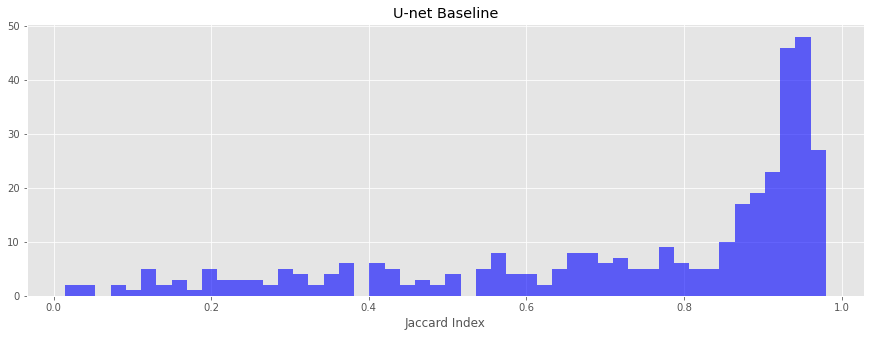

In [29]:
plt.figure(figsize=(15,5))
plt.style.use('ggplot')
plt.xlabel('Jaccard Index')
plt.title(model_name)
plt.hist(ordered_results.values(), color='b', alpha=0.6, bins=50)
plt.show()

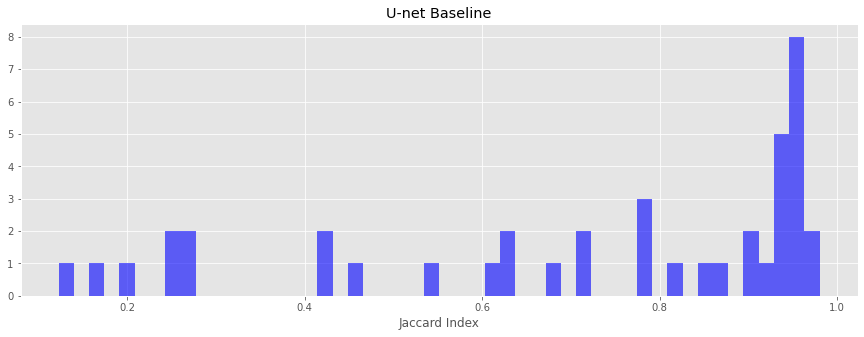

In [30]:
plt.figure(figsize=(15,5))
plt.style.use('ggplot')
plt.xlabel('Jaccard Index')
plt.title(model_name)
plt.hist(filtered_results.values(), color='b', alpha=0.6, bins=50)
plt.show()